In [1]:
from sympy import *
init_printing(wrap_line=True)
from itertools import product
from IPython.display import display, Math

In [2]:
from sympy.printing.latex import LatexPrinter

class Printer(LatexPrinter):
    def _print_list(self, l):
        items = []

        for expr in l:
            if type(expr) is tuple:
                items.append("%s &= %s" % (self._print(expr[0]), self._print(expr[1])))
            else:
                items.append("%s &= %s" % (self._print(expr.lhs), self._print(expr.rhs)))

        return r"\begin{align} %s \end{align}" % r", \\ ".join(items)
    
def aligned(expr):
    return Math(Printer().doprint(expr))

In [3]:
# copy of `sympy.integrals.quadrature.gauss_hermite` sans evaluation
def gauss_hermite(n):
    x = Dummy("x")
    p  = hermite_poly(n, x, polys=True)
    p1 = hermite_poly(n-1, x, polys=True)
    xi = []
    w  = []
    for r in p.real_roots():
        xi.append(r)
        w.append(((2**(n-1) * factorial(n) * sqrt(pi))/(n**2 * p1.subs(x, r)**2)))
    return xi, w

In [4]:
def eq2assgn(m):
    return list(map(lambda expr: (expr.lhs, expr.rhs), m))

# Symbolic generation of GPU-based Lattice Boltzmann implementations

#### Adrian Kummerländer

## Lattice Boltzmann Method
  
  
$$\begin{align*}\Omega(f) &= \left( \partial_t + \xi \, \partial_x + \frac{F}{\rho} \, \partial_\xi \right) f && \text{Boltzmann equation} \\ \Omega(f) :&= -\frac{f-f^\text{eq}}{\tau} \Delta t &&\text{BGK collision operator}\\ (\partial_t + \xi_i \cdot \nabla_x) f_i(x,t) &= -\frac{1}{\tau} (f_i(x,t) - f_i^\text{eq}(x,t)) &&\text{BGK approximation} \\ f_i^\text{eq} :&= \omega_i \rho \left( 1 + \frac{u \cdot \xi_i}{c_s^2} + \frac{(u \cdot \xi_i)^2}{2c_s^4} - \frac{u \cdot u}{2c_s^2} \right) &&\text{Discrete equilibrium} \\ \overline{f_i}(x+\xi_i,t+1) &= \overline{f_i}(x,t) - \frac{1}{\overline\tau} (\overline{f_i}(x,t) - f_i^\text{eq}(x,t)) &&\text{Discrete LBM BGK equation}
\end{align*}$$

…nothing special.

## Experimental symbolic differentiation

```
% derivative of x is 1
diff(X, X, 1) :- !. % cut to prevent further rule applications

% derivative of a constant is 0
diff(C, X, 0) :- number(C).

% sum rule
diff(U+V, X, D) :- diff(U, X, DU), diff(V, X, DV), D = DU + DV.
diff(U-V, X, D) :- diff(U, X, DU), diff(V, X, DV), D = DU - DV.

% product rule
diff(U*V, X, U*DV+V*DU) :- diff(U, X, DU), diff(V, X, DV).

% quotient rule
diff(U/V, X, (DU*V-DV*U)/(V*V)) :- diff(U, X, DU), diff(V, X, DV).

% some special derivatives
diff(sin(U), X,   DU*cos(U))  :- diff(U, X, DU).
diff(cos(U), X, -(DU*sin(U))) :- diff(U, X, DU).
diff(log(U), X, DU/U) :- diff(U, X, DU).
```

```
?- diff(x*x,x,D).
D = x*1+x*1.

?- diff(3*sin(x*x),x,D).
D = 3*((x*1+x*1)*cos(x*x))+sin(x*x)*0.

?- diff(x*x*x+2*x+log(x),x,D).
D = x*x*1+x*(x*1+x*1)+(2*1+x*0)+1/x.
```

In [5]:
x = symbols('x')
diff(x**3+2*x+log(x),x)

## Characteristic constants

In [6]:
d = 2
q = 9

In [7]:
c = [ Matrix(x) for x in product([-1,0,1], repeat=d) ]

In [8]:
c

⎡⎡-1⎤  ⎡-1⎤  ⎡-1⎤  ⎡0 ⎤  ⎡0⎤  ⎡0⎤  ⎡1 ⎤  ⎡1⎤  ⎡1⎤⎤
⎢⎢  ⎥, ⎢  ⎥, ⎢  ⎥, ⎢  ⎥, ⎢ ⎥, ⎢ ⎥, ⎢  ⎥, ⎢ ⎥, ⎢ ⎥⎥
⎣⎣-1⎦  ⎣0 ⎦  ⎣1 ⎦  ⎣-1⎦  ⎣0⎦  ⎣1⎦  ⎣-1⎦  ⎣0⎦  ⎣1⎦⎦

## Derivation of weights

Weights of third order Hermite polynomial:

$$\eta_{-1} = \frac{\sqrt{\pi}}{6},\ \eta_0 = \frac{2 \sqrt{\pi}}{3},\ \eta_1 = \frac{\sqrt{\pi}}{6}$$

Weight formulation:

$$\omega_i = \frac{1}{\sqrt{\pi^{d}}} \prod_{j=0}^{d-1} \eta_{(\xi_i)_j}$$

In [9]:
def weights(d, c):
    _, omegas = gauss_hermite(3)
    return list(map(
        lambda c_i: Mul(*[ omegas[1+c_i[iDim]] 
                          for iDim in range(0,d) ]) / pi**(d/2),
        c))

In [10]:
w = weights(d, c)
w

In [11]:
sum(w)

## Recovering the speed of sound

$$\sum_{i=1}^{q-1} \omega_i (\xi_i)_a (\xi_i)_b = c_s^2 \delta_{a,b}$$


In [12]:
def c_s(d, c, w):
    speeds = set([ sqrt(sum([ w[i] * c_i[j]**2
                             for i, c_i in enumerate(c) ])) 
                  for j in range(0,d) ])
    assert len(speeds) == 1 # verify isotropy
    return speeds.pop()

In [13]:
cs = c_s(d, c, w)
cs

## Moments

In [14]:
rho = symbols('rho')
u   = Matrix(symarray('u', d))

In [15]:
f_next = symarray('f_next', q)
f_next

array([f_next_0, f_next_1, f_next_2, f_next_3, f_next_4, f_next_5,
       f_next_6, f_next_7, f_next_8], dtype=object)

In [16]:
f_curr = symarray('f_curr', q)
f_curr

array([f_curr_0, f_curr_1, f_curr_2, f_curr_3, f_curr_4, f_curr_5,
       f_curr_6, f_curr_7, f_curr_8], dtype=object)

In [17]:
moments = [ Eq(rho, sum(f_curr)) ]
moments

In [18]:
for i, u_i in enumerate(u):
    moments.append(
        Eq(u_i,
           sum([ (c_j*f_curr[j])[i] for j, c_j in enumerate(c) ]) / sum(f_curr)))
aligned(moments)

<IPython.core.display.Math object>

## Discrete equilibrium

In [19]:
f_eq = []

for i, c_i in enumerate(c):
    f_eq_i = w[i] * rho * (  1
                           + c_i.dot(u)    /    cs**2
                           + c_i.dot(u)**2 / (2*cs**4)
                           - u.dot(u)      / (2*cs**2) )
    f_eq.append(f_eq_i)

f_eq

## BGK Collision

In [20]:
tau = symbols('tau')

In [21]:
collide = [ Eq(f_next[i],
               f_curr[i] + 1/tau * ( f_eq_i - f_curr[i] ))
           for i, f_eq_i in enumerate(f_eq) ]
aligned(collide)

<IPython.core.display.Math object>

In [22]:
def bgk_collide(m):
    return list(map(lambda expr: expr.subs(eq2assgn(m)), collide))

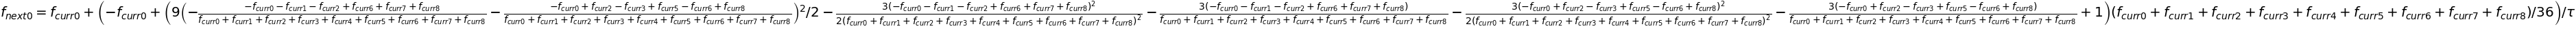

In [23]:
lbm = bgk_collide(moments)
lbm[0]

## Common subexpression elimination (CSE)

In [24]:
subexprs, exprs = cse(lbm, optimizations='basic')

In [25]:
aligned(subexprs[0:8])

<IPython.core.display.Math object>

In [26]:
aligned(exprs)

<IPython.core.display.Math object>

### Number of operations

In [27]:
count_ops(lbm)

In [28]:
count_ops([subexprs, exprs])

### Number of operations in the actual implementation

| Model | No-CSE | CSE | Reduction |
| ----- | ------ | --- | ----------- |
| D2Q9  | 109    | 72  | ~34% |
| D3Q19 | 287    | 152 | ~47% |
| D3Q27 | 435    | 214 | ~50% |

## Code generation

In [29]:
for expr in subexprs:
    print("const float %s = %s;" % (expr[0], ccode(expr[1])))

const float x0 = f_curr_0 + f_curr_1 + f_curr_2 + f_curr_3 + f_curr_4 + f_curr_5 + f_curr_6 + f_curr_7 + f_curr_8;
const float x1 = -f_curr_3 + f_curr_5;
const float x2 = -f_curr_0 + f_curr_8;
const float x3 = f_curr_2 - f_curr_6;
const float x4 = x1 + x2 + x3;
const float x5 = 6/x0;
const float x6 = x4*x5;
const float x7 = 2*f_curr_0;
const float x8 = 2*f_curr_8;
const float x9 = -f_curr_1 + f_curr_7;
const float x10 = pow(x0, -2);
const float x11 = 9*x10;
const float x12 = -f_curr_2 + f_curr_6;
const float x13 = x12 + x2 + x9;
const float x14 = pow(x4, 2);
const float x15 = 3*x10;
const float x16 = pow(x13, 2)*x15 - 2;
const float x17 = x14*x15 + x16;
const float x18 = 1.0/tau;
const float x19 = (1.0/72.0)*x18;
const float x20 = f_curr_0 - f_curr_8;
const float x21 = f_curr_1 - f_curr_7;
const float x22 = x20 + x21 + x3;
const float x23 = x22*x5;
const float x24 = pow(x22, 2);
const float x25 = 6*x10;
const float x26 = f_curr_3 - f_curr_5;
const float x27 = x12 + x20 + x26;
const flo

In [30]:
for i, expr in enumerate(exprs):
    print("%s = %s;" % (ccode(expr.lhs), ccode(expr.rhs)))

f_next_0 = f_curr_0 - x19*(72*f_curr_0 + x0*(-x11*pow(x1 - x7 + x8 + x9, 2) + x13*x5 + x17 + x6));
f_next_1 = f_curr_1 - x31*(18*f_curr_1 - x0*(x23 + x30));
f_next_2 = f_curr_2 - x19*(72*f_curr_2 - x0*(x23 + x34 + x35));
f_next_3 = f_curr_3 - x31*(18*f_curr_3 + x0*(-x14*x25 + x16 + x6));
f_next_4 = f_curr_4 - 1.0/9.0*x18*(9*f_curr_4 + 2*x0*x17);
f_next_5 = f_curr_5 - x31*(18*f_curr_5 - x0*(x25*x28 + x34 + 2));
f_next_6 = f_curr_6 - x19*(72*f_curr_6 - x0*(x32 + x33 + x35 + x36));
f_next_7 = f_curr_7 - x31*(18*f_curr_7 - x0*(x30 + x36));
f_next_8 = f_curr_8 - x19*(72*f_curr_8 - x0*(x11*pow(x21 + x26 + x7 - x8, 2) + x29 + x34 + x36));


## Evaluation

## Measuring performance

$$\text{MLUPS} := \frac{n_\text{cells} \ n_\text{updates}}{10^6 \, \Delta t}$$


### Theoretical maximum performance

$$\text{MLUPS}_\text{max} := \frac{B_\text{max}}{B_\text{update} 10^6}$$


| GPU    | Bandwidth   | D2Q9   | &nbsp; | D3Q19  | &nbsp; | D3Q27  | &nbsp; | 
| ------ | ----------- | ------ | ------ | ------ | ------ | ------ | ------ |
| &nbsp; | &nbsp;      | single | double | single | double | single | double | 
| P100   | 512.6 GiB/s | 7242   | 3719   | 3528   | 1787   | 2502   | 1262   |

### Measured performance...

| CSE    | D2Q9   | &nbsp; | D3Q19  | &nbsp; | D3Q27  | &nbsp; |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| &nbsp; | single | double | single | double | single | double |
| No     | 6957.4 | 2814.4 | 2581.8 |  998.8 | 1576.4 |  647.4 |
| Yes    | 6922.4 | 3585.0 | 3420.2 | 1763.8 | 2374.6 | 1259.6 |

### …compared to theoretical maximum

| CSE    | D2Q9   | &nbsp; | D3Q19  | &nbsp; | D3Q27  | &nbsp; |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| &nbsp; | single | double | single | double | single | double |
| No     | 96.1%  | 75.7%  | 73.2%  | 55.9%  | 63.0%  | 51.3%  |
| Yes    | 95.6%  | 96.4%  | 96.9%  | 98.7%  | 94.9%  | 99.8%  |

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
from result.ldc_2d_benchmark_P100  import ldc_2d_p100
from result.ldc_3d_benchmark_P100  import ldc_3d_p100

p100_max_bandwidth = 512.6*1024**3

def max_mlups(b, q, precision):
    return b / ((2*q*precision+4)*10**6)

def descriptor_subset(data, descriptor):
    return list(
        map(lambda m: (m[0][0:2] + m[0][3:], m[1]),
            filter(lambda m: m[0][2] == descriptor, data)))

ldc_3d_D3Q19_p100  = descriptor_subset(ldc_3d_p100,  'symbolic.D3Q19')
ldc_3d_D3Q27_p100  = descriptor_subset(ldc_3d_p100,  'symbolic.D3Q27')

def values(data, index):
    return set(map(lambda m: m[0][index], data))

def has(value, options):
    if options == None:
        return True
    elif callable(options):
        return options(value)
    else:
        return value in options

def subset(data, size=None, layout=None, precision=None, optimization=None, align=None):
    return list(
        filter(lambda m: has(m[0][0], size) and
               has(m[0][1][0], layout) and
               has(m[0][2], precision) and
               has(m[0][3], optimization) and
               has(m[0][4], align),
               data))

def mlups_for_size(measurement):
    dim = len(list(measurement[0][1]))
    return (measurement[0][0]**dim, numpy.average(measurement[1]))

def scatter(data, **kwargs):
    plt.scatter(*zip(*list(data)), **kwargs)
    
def mlups_per_size_overview_plot(data, title, **kwargs):
    plt.figure(figsize=(11,7.5))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Cells')
    plt.ylabel('MLUPS')
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%4d'))
    scatter(map(mlups_for_size, subset(data, precision=['single'], optimization=[True], **kwargs)), label='single, CSE', s=16)
    scatter(map(mlups_for_size, subset(data, precision=['double'], optimization=[True], **kwargs)), label='double, CSE', s=16)
    scatter(map(mlups_for_size, subset(data, precision=['single'], optimization=[False], **kwargs)), label='single, not-CSE', s=16)
    scatter(map(mlups_for_size, subset(data, precision=['double'], optimization=[False], **kwargs)), label='double, not-CSE', s=16)
    plt.legend()

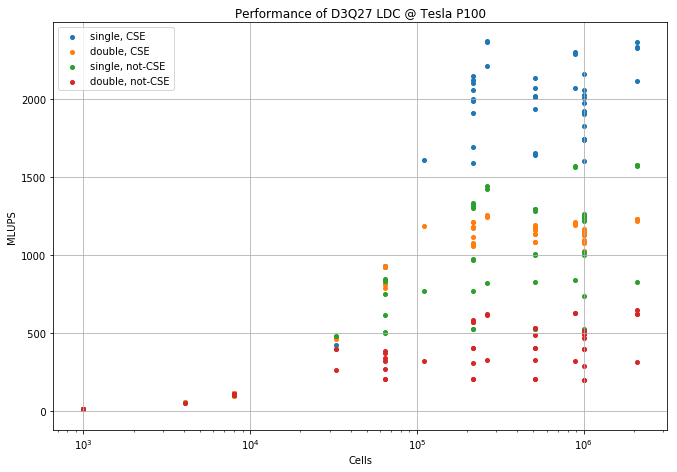

In [32]:
mlups_per_size_overview_plot(ldc_3d_D3Q27_p100, 'Performance of D3Q27 LDC @ Tesla P100')

### Some references

- T. Krüger, H. Kusumaatmaja, A. Kuzmin, O. Shardt, G. Silva, and E. M. Viggen. The Lattice Boltzmann Method: Principles and Practice. Graduate Texts in Physics. Springer International Publishing, 2017.
- Xiaoyi He and Li-Shi Luo. “Theory of the lattice Boltzmann method: From the Boltzmann equation to the lattice Boltzmann equation”. In: PHYSICAL REVIEW E 56 (Dec. 1997), pp. 6811–6817.
- Michal Januszewski and Marcin Kostur. “Sailfish: a flexible multi-GPU implementation of the lattice Boltzmann method”. In: (2013). doi: 10.1016/j.cpc.2014.04.018. eprint: arXiv:1311.2404.

### Try it out for yourself

https://code.kummerlaender.eu/opencl_playground/